In [1]:
from laplace.baselaplace import FullLaplace
from laplace.curvature.backpack import BackPackGGN
import numpy as np
import torch

from laplace import Laplace, marglik_training
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import pandas as pd
import h5py

Epoch [100/5000], Loss: 0.5866
Epoch [200/5000], Loss: 0.4972
Epoch [300/5000], Loss: 0.6213
Epoch [400/5000], Loss: 0.6584
Epoch [500/5000], Loss: 0.4349
Epoch [600/5000], Loss: 0.3784
Epoch [700/5000], Loss: 0.4858
Epoch [800/5000], Loss: 0.4990
Epoch [900/5000], Loss: 0.5519
Epoch [1000/5000], Loss: 0.4316
Epoch [1100/5000], Loss: 0.4723
Epoch [1200/5000], Loss: 0.4978
Epoch [1300/5000], Loss: 0.4527
Epoch [1400/5000], Loss: 0.5090
Epoch [1500/5000], Loss: 0.5548
Epoch [1600/5000], Loss: 0.3838
Epoch [1700/5000], Loss: 0.4320
Epoch [1800/5000], Loss: 0.5343
Epoch [1900/5000], Loss: 0.4001
Epoch [2000/5000], Loss: 0.4943
Epoch [2100/5000], Loss: 0.3791
Epoch [2200/5000], Loss: 0.4533
Epoch [2300/5000], Loss: 0.4537
Epoch [2400/5000], Loss: 0.4663
Epoch [2500/5000], Loss: 0.3968
Epoch [2600/5000], Loss: 0.4089
Epoch [2700/5000], Loss: 0.4813
Epoch [2800/5000], Loss: 0.4931
Epoch [2900/5000], Loss: 0.5345
Epoch [3000/5000], Loss: 0.4767
Epoch [3100/5000], Loss: 0.5837
Epoch [3200/5000]

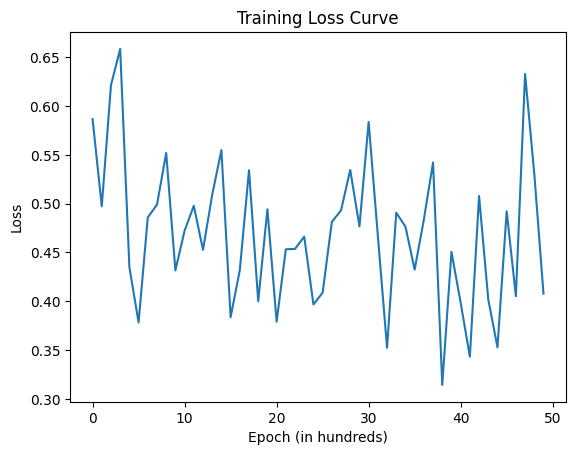

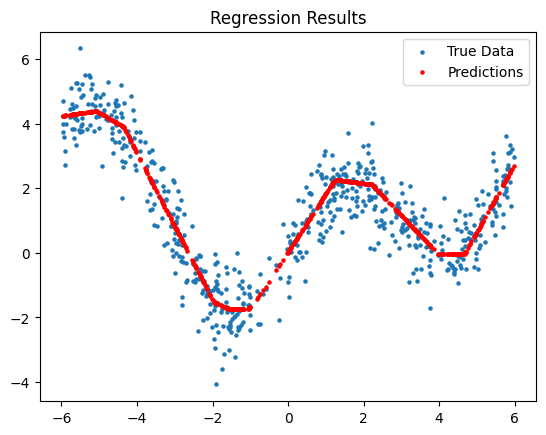

In [2]:
torch.manual_seed(42)  # for reproducibility

def generate_data(N=2000, test_ratio=0.5):
    # Calculate sizes
    test_size = int(N * test_ratio)
    train_size = N - test_size
    
    # Generate x for training data ensuring no points between -1 and 0
    train_x = torch.empty(train_size, 1)
    idx = 0
    while idx < train_size:
        sample = torch.rand(1) * 12 - 6
        if sample <= -1 or sample >= 0:
            train_x[idx] = sample
            idx += 1
    
    # Generate x for test data without any restrictions
    test_x = torch.rand(test_size) * 12 - 6
    test_x = torch.unsqueeze(test_x, dim=1)
    
    # Concatenate training and test x values
    x = torch.cat((train_x, test_x), 0)
    
    # Calculate y values for entire dataset
    y = 2 * torch.sin(x) + 0.1 * x.pow(2) + torch.normal(0, 0.7, size=(N, 1))
    
    # Shuffle the data
    indices = torch.randperm(N)
    shuffled_x = x[indices]
    shuffled_y = y[indices]
    
    # Split data into training and test sets
    train_x = shuffled_x[:train_size]
    train_y = shuffled_y[:train_size]
    test_x = shuffled_x[train_size:]
    test_y = shuffled_y[train_size:]
    
    return test_x, test_y, train_x, train_y

# Neural network definition
class ExtendedNN(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim):
        super(ExtendedNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Train the model function
def train_model(model, data_loader, criterion, optimizer, num_epochs=1000):
    losses = []
    for epoch in range(num_epochs):
        for inputs, targets in data_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if (epoch+1) % 100 == 0:
            losses.append(loss.item())
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")
    return losses

test_x, test_y, train_x, train_y = generate_data(N=2000, test_ratio=0.3)

# Create DataLoader for training data
train_dataset = TensorDataset(train_x, train_y)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

input_dim = 1
hidden_dim1 = 15
hidden_dim2 = 5
output_dim = 1
model = ExtendedNN(input_dim, hidden_dim1, hidden_dim2, output_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

losses = train_model(model, train_loader, criterion, optimizer, num_epochs=5000)

# Plot the loss curve
plt.plot(losses)
plt.xlabel('Epoch (in hundreds)')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.show()

# Test the model
model.eval()  # set the model to evaluation mode
with torch.no_grad():
    test_outputs = model(test_x)
    
plt.scatter(test_x, test_y, label='True Data', s=5)
plt.scatter(test_x, test_outputs, color='red', label='Predictions', s=5)
plt.legend()
plt.title('Regression Results')
plt.show()

# Testing the laplace API from Alex Immer

## Fitting and optimizing the Laplace approximation using empirical Bayes

In [3]:
la = Laplace(model, 'regression', subset_of_weights='all', hessian_structure='full')
la.fit(train_loader)
log_prior, log_sigma = torch.ones(1, requires_grad=True), torch.ones(1, requires_grad=True)
hyper_optimizer = torch.optim.Adam([log_prior, log_sigma], lr=1e-1)
n_epochs = 10000
for i in range(n_epochs):
    hyper_optimizer.zero_grad()
    neg_marglik = - la.log_marginal_likelihood(log_prior.exp(), log_sigma.exp())
    neg_marglik.backward()
    hyper_optimizer.step()

/Users/noahliniger/opt/miniconda3/envs/dslab/lib/python3.9/site-packages/backpack/extensions/backprop_extension.py:106: UserWarning: Extension saving to grad_batch does not have an extension for Module <class '__main__.ExtendedNN'> although the module has parameters
  warnings.warn(


In [4]:
x = test_x.flatten().cpu().numpy()
f_mu, f_var = la(test_x)
f_mu = f_mu.squeeze().detach().cpu().numpy()
f_sigma = f_var.squeeze().sqrt().cpu().numpy()
pred_std = np.sqrt(f_sigma**2 + la.sigma_noise.item()**2)

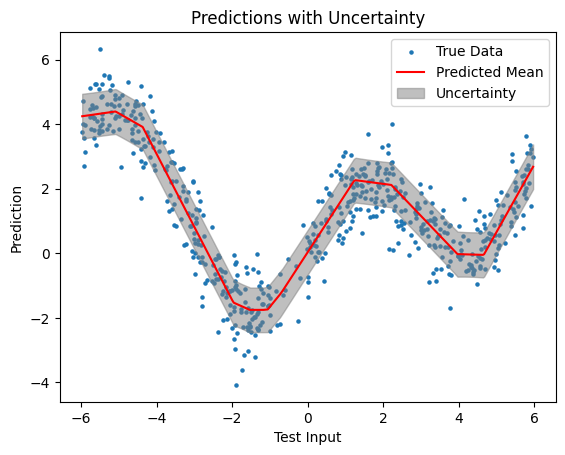

In [5]:
# Order x and apply the same ordering to f_mu and pred_std
order = np.argsort(x)
x = x[order]
f_mu = f_mu[order]
pred_std = pred_std[order]

plt.scatter(test_x, test_y, label='True Data', s=5)
plt.plot(x, f_mu, 'r-', label="Predicted Mean")
plt.fill_between(x, f_mu - pred_std, f_mu + pred_std, color='gray', alpha=0.5, label="Uncertainty")

plt.xlabel("Test Input")
plt.ylabel("Prediction")
plt.title("Predictions with Uncertainty")
plt.legend()
plt.show()

## Marginal likelyhood training

In [6]:
test_x, test_y, train_x, train_y = generate_data(N=3000, test_ratio=0.5)
model2 = ExtendedNN(input_dim, hidden_dim1, hidden_dim2, output_dim)

train_dataset = TensorDataset(train_x, train_y)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

x_t = torch.vstack(tensors=(test_x, train_x))
y_t = torch.vstack(tensors=(test_y, train_y))
x_t, sorted_indices = test_x.sort(dim=0)
y_t = y_t[sorted_indices.squeeze()]

In [7]:
la, model, margliks, losses = marglik_training(
    model=model2, train_loader=train_loader, likelihood='regression',
    hessian_structure='full', backend=BackPackGGN, n_epochs=1000, 
    optimizer_kwargs={'lr': 1e-3}, prior_structure='scalar'
)

In [8]:
f_mu, f_var = la(x_t)
f_mu = f_mu.squeeze().detach().cpu().numpy()
f_sigma = f_var.squeeze().sqrt().cpu().numpy()
pred_std = np.sqrt(f_sigma**2 + la.sigma_noise.item()**2)

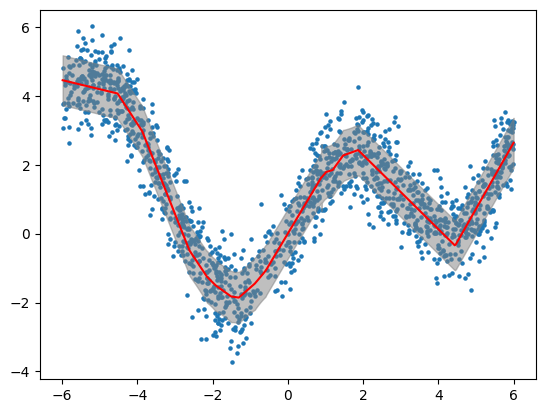

In [9]:
plt.scatter(x_t.squeeze(), y_t.squeeze(), label='True Data', s=5)
plt.plot(x_t.squeeze(), f_mu, 'r-', label="Predicted Mean")
plt.fill_between(x_t.squeeze(), f_mu - pred_std, f_mu + pred_std, color='gray', alpha=0.5, label="Uncertainty")

# Preprocessing tests

In [2]:
from WaveformDataset import WaveformDataset
from torch.utils.data import ConcatDataset, DataLoader

# h5_file = '..//data//chunk3.hdf5'
# dataset = WaveformDataset(csv_file=csv_file, h5_file=h5_file)

csv_files = ['..//data//chunk2.csv']#, '..//data//chunk3.csv', '..//data//chunk4.csv']
h5_files = ['..//data//chunk2.hdf5']#, '..//data//chunk3.hdf5', '..//data//chunk4.hdf5']

datasets = [WaveformDataset(csv_file=csv_files[i], h5_file=h5_files[i]) for i in range(len(csv_files))]

# Concatenate the datasets
concatenated_dataset = ConcatDataset(datasets)

# Now you can use the concatenated dataset with a DataLoader
print("creating dataloader")
dataloader = DataLoader(concatenated_dataset, batch_size=64, shuffle=True, num_workers=4)

creating dataloader


In [5]:
from torch.nn import MaxPool1d
from torch.nn import Conv1d
from torch.nn import Linear
from torch.nn import ReLU
from torch.nn import Flatten

class CNNNet(torch.nn.Module):
    def __init__(self, num_channels=1):
        super(CNNNet, self).__init__()
        self.relu = ReLU()
        self.flatten = torch.nn.Flatten()
        filter1 = 21
        filter2 = 15
        filter3 = 8

        linear_shape = 23392

        self.maxpool = MaxPool1d(kernel_size=10, stride=2)
        self.conv1 = Conv1d(num_channels, 32,
                            kernel_size=filter1, padding=filter1 // 2)
        self.bn1 = torch.nn.BatchNorm1d(32, eps=1e-05, momentum=0.1)

        self.conv2 = Conv1d(32, 32,
                            kernel_size=filter2, padding=filter2 // 2)
        self.bn2 = torch.nn.BatchNorm1d(32, eps=1e-05, momentum=0.1)

        self.conv3 = Conv1d(32, 32,
                            kernel_size=filter3, padding=filter3 // 2)
        self.bn3 = torch.nn.BatchNorm1d(32, eps=1e-05, momentum=0.1)

        self.fcn1 = Linear(linear_shape, 256)
        self.bn4 = torch.nn.BatchNorm1d(256, eps=1e-05, momentum=0.1)

        self.fcn2 = Linear(256, 128)
        self.bn5 = torch.nn.BatchNorm1d(128, eps=1e-05, momentum=0.1)

        self.fcn3 = Linear(128, 2)

    def forward(self, x):
        # N.B. Consensus seems to be growing that BN goes after nonlinearity
        # That's why this is different than Zach's original paper.
        # First convolutional layer
        print(x.shape)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.bn1(x)
        x = self.maxpool(x)
        print(x.shape)
        # Second convolutional layer
        x = self.conv2(x)
        x = self.relu(x)
        x = self.bn2(x)
        x = self.maxpool(x)
        print(x.shape)
        # Third convolutional layer
        x = self.conv3(x)
        x = self.relu(x)
        x = self.bn3(x)
        x = self.maxpool(x)
        print(x.shape)
        # Flatten
        x = self.flatten(x)
        print(x.shape)
        # First fully connected layer
        x = self.fcn1(x)
        x = self.relu(x)
        x = self.bn4(x)
        print(x.shape)
        # Second fully connected layer
        x = self.fcn2(x)
        x = self.relu(x)
        x = self.bn5(x)
        print(x.shape)
        # Last layer
        x = self.fcn3(x)
        print(x.shape)
        return x

net = CNNNet()

dataloader = DataLoader(concatenated_dataset, batch_size=64, shuffle=True, num_workers=4)

for signals, labels, snrs in dataloader: break

signals = signals.reshape(64,1,-1)

net(signals)



torch.Size([64, 1, 5900])
torch.Size([64, 32, 2946])
torch.Size([64, 32, 1469])
torch.Size([64, 32, 731])
torch.Size([64, 23392])
torch.Size([64, 256])
torch.Size([64, 128])
torch.Size([64, 2])


tensor([[-0.1937, -0.6643],
        [-0.4468, -0.6950],
        [-0.8010, -0.6615],
        [ 0.2935,  0.6222],
        [ 0.1867, -0.3300],
        [-0.3963, -0.2381],
        [-0.1462, -0.7587],
        [ 0.1365,  1.1105],
        [-0.0121,  0.0491],
        [-0.5099, -0.7884],
        [ 0.1044,  0.0459],
        [-0.3401,  0.6363],
        [ 0.2153,  0.4204],
        [ 0.6012,  0.9286],
        [ 0.0599, -0.3741],
        [ 0.3484,  1.8019],
        [ 0.0836,  1.0714],
        [ 1.0044, -0.7939],
        [ 0.4892,  0.4689],
        [ 0.2559,  0.3705],
        [ 0.3649,  0.4737],
        [-0.0715,  0.2369],
        [ 0.8377, -0.5034],
        [ 0.6451, -0.0426],
        [ 0.7297, -0.1837],
        [-0.4141,  0.0940],
        [ 0.8238,  0.3734],
        [ 0.0581,  0.1221],
        [ 0.2726, -0.0613],
        [ 0.7897, -0.4623],
        [ 0.1833, -0.1100],
        [ 0.0858, -1.2224],
        [ 0.2165,  0.2014],
        [ 0.3892,  0.3202],
        [ 0.0267, -1.2826],
        [ 0.6596, -0

In [48]:
sum(p.numel() for p in net.parameters())

6046913

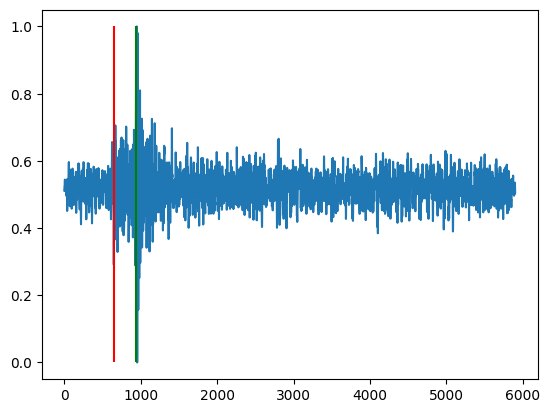

In [16]:
all_labels = []
from tqdm import tqdm

# Iterate over your DataLoader to collect all labels
# for _, labels, _ in tqdm(dataloader):
#     # Labels are expected to be a batch of tensors, so they need to be concatenated
#     all_labels.append(labels)

for series, labels, _ in dataloader:
    # Labels are expected to be a batch of tensors, so they need to be concatenated
    plt.plot(series[0,:])
    plt.vlines(labels[0,0], ymin=0, ymax=1, colors='r')
    plt.vlines(labels[0,1], ymin=0, ymax=1, colors='g')
    break

1

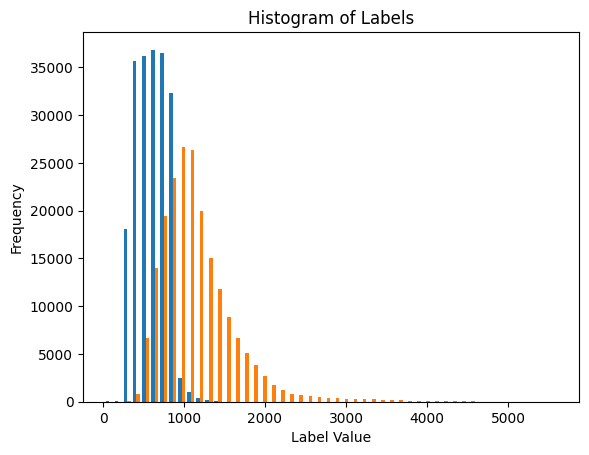

In [ ]:
# Now you have a list of batches, you need to concatenate them into a single tensor
all_labels = torch.cat(all_labels, dim=0)

# Convert to a NumPy array for plotting
all_labels = all_labels.numpy()

# Assuming each label is a scalar, you can plot a histogram directly.
# If labels are multi-dimensional, you'll need to adjust this accordingly.
plt.hist(all_labels, bins=50)  # Adjust the number of bins as needed
plt.xlabel('Label Value')
plt.ylabel('Frequency')
plt.title('Histogram of Labels')
plt.show()

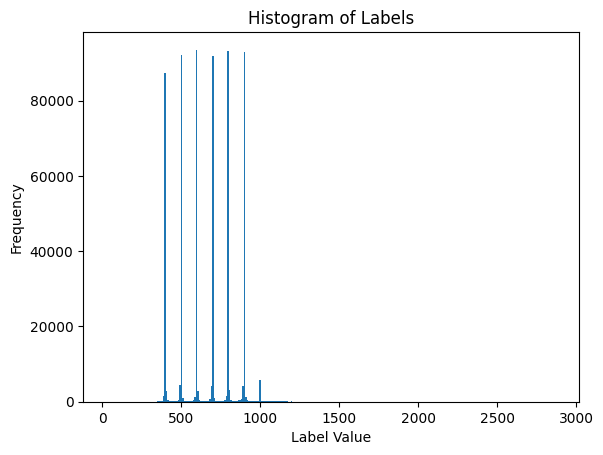

array([ 700.,  700.,  799.,  600.,  351.,  700.,  395.,  400.,  800.,
        500.,  497.,  600.,  800.,  505.,  497.,  715.,  691.,  800.,
        800.,  600.,  897.,  900.,  699.,  599.,  600.,  400.,  416.,
        700.,  796.,  500.,  800.,  906.,  796.,  600.,  497.,  500.,
        700.,  900.,  800.,  799.,  500.,  500.,  700.,  400.,  700.,
        600.,  398.,  700.,  900.,  900.,  599.,  699.,  700.,  505.,
        400.,  900.,  600.,  500.,  393.,  899.,  600.,  400.,  700.,
        700.,  798.,  800.,  500.,  500.,  400.,  500.,  600.,  900.,
        600.,  600.,  797.,  700.,  600.,  401.,  800.,  600.,  400.,
        598.,  900.,  800.,  700.,  799.,  500.,  400.,  900.,  393.,
        500.,  400.,  800.,  900.,  700., 1000.,  400.,  600.,  805.,
        600.], dtype=float32)

In [52]:
plt.hist(np.round(all_labels[:,0]), bins=300)
#plt.hist(all_labels[:,1], bins=100)
plt.xlabel('Label Value')
plt.ylabel('Frequency')
plt.title('Histogram of Labels')
plt.show()
np.round(all_labels)[:100,0]

In [43]:
from collections import Counter

# Count the occurrences of each value in the tensor
counter = Counter(all_labels[:,0])
print(len(counter))

# Get the 10 most common values
most_common = counter.most_common(20)

# Print the 10 most common values and their counts
for value, count in most_common:
    print(f"Value: {value}, Count: {count}")

len(all_labels[:,0])

print(np.sum(np.logical_and(all_labels[:,0] > 300, all_labels[:,0] < 1000))/len(all_labels[:,0]))
print(len(all_labels[:,0]))


5968
Value: 600.0, Count: 74333
Value: 900.0, Count: 74070
Value: 500.0, Count: 73749
Value: 800.0, Count: 73736
Value: 700.0, Count: 73597
Value: 400.0, Count: 68183
Value: 899.0, Count: 7864
Value: 699.0, Count: 7824
Value: 499.0, Count: 7778
Value: 799.0, Count: 7702
Value: 599.0, Count: 7496
Value: 399.0, Count: 7472
Value: 1000.0, Count: 5543
Value: 597.0, Count: 2945
Value: 497.0, Count: 2752
Value: 897.0, Count: 2749
Value: 697.0, Count: 2678
Value: 397.0, Count: 2644
Value: 797.0, Count: 2612
Value: 798.0, Count: 2176
0.985675
600000
